#Customer segmentation with clustering

## **Business context**
E-commerce data set is used to perform customer segmentation with clustering models to improve marketing efforts. This is a transnational data set with customers from five continents (Oceania, North America, Europe, Africa, and Asia) and 47 countries.

## **Objective**

Develop a robust customer segmentation to assist the e-commerce company in understanding and serving its customers better. This will help to have a more customer-centric focus, improving marketing efficiency.
The data set contains 951,668 rows, each representing a product a customer ordered. The data set contains details about the customer (e.g. location, product type, loyalty member) and order (e.g. days to delivery, delivery date, order date, cost, quantity ordered, profit) based on orders between 1 January 2012 and 30 December 2016.



# **1.** Import the required libraries and data set with the provided URL.

In [ ]:
# Import the required libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE

import warnings

# Ignore all FutureWarnings
warnings.simplefilter("ignore", category=FutureWarning)

In [ ]:
# Read the CSV file into a new DataFrame.
customer_data = pd.read_csv('/content/CUSTOMERS_CLEAN.csv')

df=customer_data.copy()

# Display the first few rows of the DataFrame.
df.head()

,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


In [ ]:
df.shape

(951669, 20)

# **2.** Performinig data pre-processing:
  - Identify missing values.
  - Check for duplicate values.
  - Determine if there are any outliers.
  - Aggregate the data into one customer per row

### **Performing EDA**

In [ ]:
# View the data set shape and features types
shape = df.shape
types = (df.dtypes)

print(shape)
print(types)

(951669, 20)
Quantity                 int64
City                    object
Continent               object
Postal_Code             object
State_Province          object
Order_Date              object
Delivery_Date           object
Total Revenue           object
Unit Cost               object
Discount                object
OrderTypeLabel          object
CustomerCountryLabel    object
Customer_BirthDate      object
Customer_Group          object
Customer_Type           object
Order ID                 int64
Profit                  object
Days to Delivery         int64
Loyalty Num              int64
Customer ID              int64
dtype: object


The dataset consists of a combination of numeric and non-numeric variables.

### **Checking for missing values and duplicates.**

In [ ]:
# Find missing values.
missings_count = df.isnull().sum()
duplicate_count = df.duplicated().sum()

print(f'Missing values: {missings_count}')
print(f'Number of duplicate rows: {duplicate_count}')

Missing values: Quantity                     0
City                       135
Continent                    0
Postal_Code               3716
State_Province          117192
Order_Date                   0
Delivery_Date                0
Total Revenue                0
Unit Cost                    0
Discount                     0
OrderTypeLabel               0
CustomerCountryLabel         0
Customer_BirthDate           0
Customer_Group               0
Customer_Type                0
Order ID                     0
Profit                       0
Days to Delivery             0
Loyalty Num                  0
Customer ID                  0
dtype: int64
Number of duplicate rows: 21


 🔍  There are 21 duplicated rows and some missing values for variables: City, Postal Code, State_Province.
I progress by removing the duplicates, however for now I do not treat the missing values in the three geographical variables as, due to business requirements, I am going to work on a smaller set of behavioural variables for clustering and the rest of the data will be removed from the analysis.

In [ ]:
df_cleaned = df.drop_duplicates()

### Converting monetary values to numeric variables

In [ ]:
# Function to clean and convert currency values
def clean_currency(value):

    if not isinstance(value, str):
        return value

    value = value.replace('$', '').replace(',', '')
    if value.startswith('(') and value.endswith(')'):
        value = '-' + value[1:-1]

    try:
        return float(value)
    except ValueError:
        return value

for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        df_cleaned[col] = df_cleaned[col].apply(clean_currency)


### **Checking outliers**

### Checking for outliers in numeric data

In [ ]:
subset_df = df_cleaned[['Quantity', 'Total Revenue', 'Unit Cost', 'Profit', 'Days to Delivery']]

In [ ]:
subset_df.head()

,Quantity,Total Revenue,Unit Cost,Profit,Days to Delivery
0,3,28.5,9.1,1.2,6
1,2,113.4,56.9,-0.4,3
2,2,41.0,18.5,4.0,3
3,1,35.2,29.6,5.6,2
4,1,24.7,23.6,1.1,3


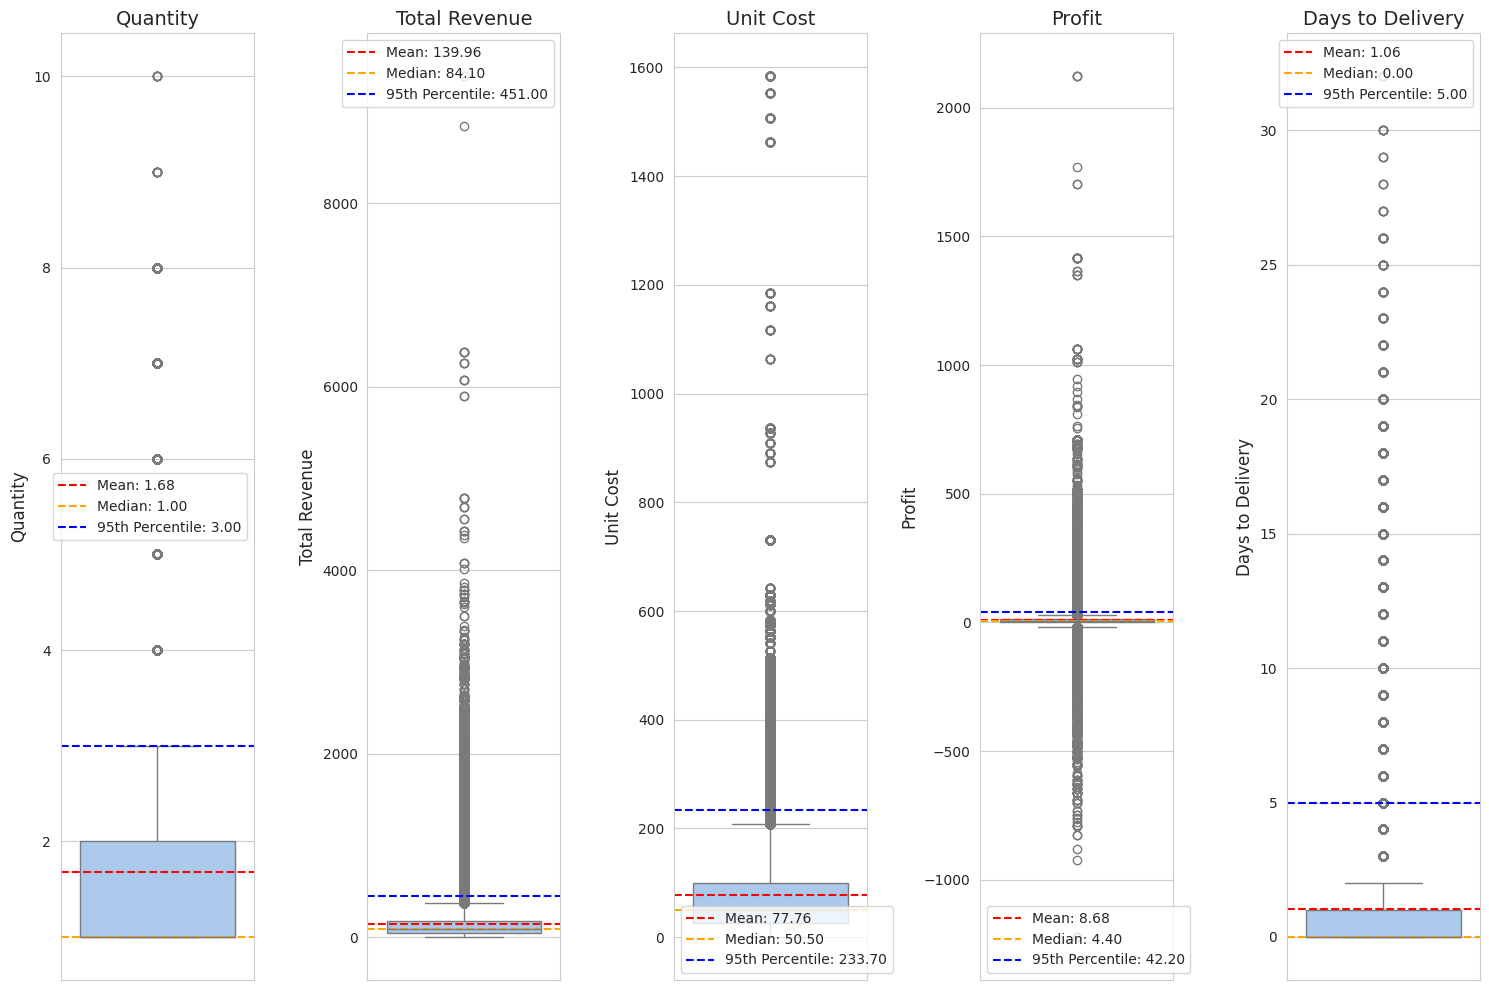

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

fig, axes = plt.subplots(nrows=1, ncols=len(subset_df.columns), figsize=(15, 10))

if len(subset_df.columns) > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, col in enumerate(subset_df.columns):
    ax = axes[i]

    sns.boxplot(data=subset_df, y=col, ax=ax)
    ax.set_title(f'{col}')

    mean_val = subset_df[col].mean()
    median_val = subset_df[col].median()
    perc_95th = np.percentile(subset_df[col], 95)

    # Adding lines for the mean and 95th percentile
    ax.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax.axhline(median_val, color='orange', linestyle='--', label=f'Median: {median_val:.2f}')
    ax.axhline(perc_95th, color='blue', linestyle='--', label=f'95th Percentile: {perc_95th:.2f}')

    ax.legend()

for j in range(len(subset_df.columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Sense-checking revenue data on its extreme values
# select where revenue is >8000

filtered_df = subset_df[subset_df['Total Revenue'] > 8000]
print(filtered_df)

        Quantity  Total Revenue  Unit Cost  Profit  Days to Delivery
151598         6         8847.6     1463.5    66.6                 0
540936         6         9385.8     1552.6    70.2                 0


📊 There is high skewness in the data, with many observations falling beyond the 95th percentile for most  of the numeric features. The observations seem genuine observations, rather than outliers to be removed.

### **Computing aggreated Customer View for clustering**

# **3.** Performing feature engineering:
  - Creating new features for frequency, recency, CLV, average unit cost, and customer age.
  - Selecting the best features for analysis.
  - Performing feature scaling and encoding if needed.

### **Create new features for frequency, recency, CLV, average unit cost, and customer age.**

In [ ]:
subset_df = df_cleaned[['Customer ID', 'Order ID', 'Customer_BirthDate', 'Total Revenue', 'Unit Cost', 'Profit', 'Delivery_Date', 'Days to Delivery']]

In [ ]:
# Frequency: Count of 'Order ID' per 'Customer ID'
df_frequency = subset_df.groupby('Customer ID').agg(
    Frequency=('Order ID', 'nunique'),  # Count distinct Order IDs
    Distinct_Dates=('Delivery_Date', 'nunique')  # Count distinct Delivery Dates
).reset_index()
df_frequency = df_frequency.drop(columns=['Distinct_Dates'])

# Recency: Time since last order in days (use the most recent date)
df_recency_temp = (pd.to_datetime('today') - pd.to_datetime(subset_df['Delivery_Date'])).dt.days
df_recency = subset_df.assign(Recency=df_recency_temp).groupby('Customer ID').agg(Recency=('Recency', 'min')).reset_index()

# Customer Lifetime Value (CLV): Sum of 'Total Revenue' per 'Customer ID'
df_clv = subset_df.groupby('Customer ID').agg(CLV=('Total Revenue', 'sum')).reset_index()

# Average Unit Cost (AUC): Average of 'Unit Cost' per 'Customer ID'
df_auc = subset_df.groupby('Customer ID').agg(Avg_Unit_Cost=('Unit Cost', 'mean')).reset_index()
df_auc['Avg_Unit_Cost'] = df_auc['Avg_Unit_Cost'].round(2)

# Customer Age: Calculating age from 'Customer_BirthDate'
df_age_temp = pd.to_datetime(subset_df['Customer_BirthDate'], format='%d%b%Y')
today = pd.Timestamp.today()
df_age = subset_df.assign(DOB=df_age_temp).groupby('Customer ID').agg(DOB=('DOB', 'max')).reset_index()
df_age['Age'] = (today - df_age['DOB']).dt.days // 365
df_age = df_age.drop(columns=['DOB'])

# Merge all DataFrames on 'Customer ID'
df_cv = df_frequency.merge(df_recency, on='Customer ID')
df_cv = df_cv.merge(df_clv, on='Customer ID')
df_cv = df_cv.merge(df_auc, on='Customer ID')
df_cv = df_cv.merge(df_age, on='Customer ID')

print(df_cv.head())
print(df_cv.shape)

<ipython-input-13-03abc92af541>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_recency_temp = (pd.to_datetime('today') - pd.to_datetime(subset_df['Delivery_Date'])).dt.days


   Customer ID  Frequency  Recency      CLV  Avg_Unit_Cost  Age
0            1         28     2965  4322.70          89.62   71
1            3         14     3067  2821.00          90.50   41
2            4          8     4056   782.67          37.20   41
3            5         15     2953  2810.98         107.95   36
4            6         13     3138  1604.58          52.53   66
(68300, 6)


### **Selecting features for analysis**

In [ ]:
df_cv_cluster = df_cv.drop(columns=['Customer ID']) ## dropping Customer ID variable from our modeling data

# **4.** Performing EDA.

### Histograms to check for distributions and outliers

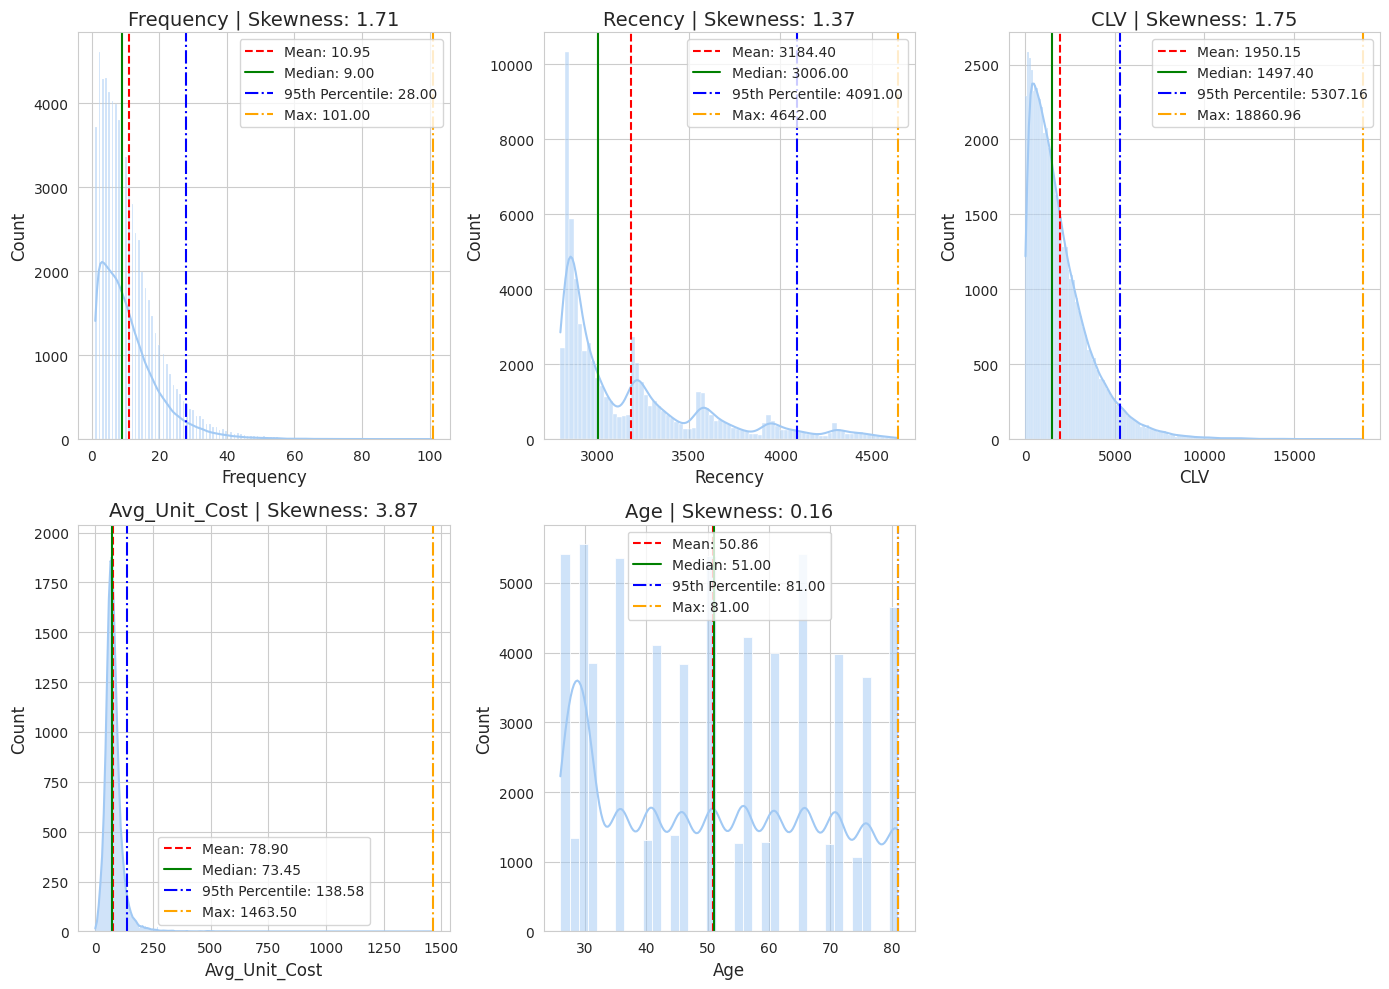

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)

# Map original column names to descriptive names
descriptive_names = {
    'Frequency': 'Frequency',
    'Recency': 'Recency',
    'CLV': 'CLV',
    'Avg_Unit_Cost': 'Avg_Unit_Cost',
    'Age': 'Age'
}

numerical_columns = df_cv_cluster.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 2))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, idx)

    sns.histplot(df_cv_cluster[feature], kde=True)

    mean_val = df_cv_cluster[feature].mean()
    median_val = df_cv_cluster[feature].median()
    perc_95th = np.percentile(df_cv_cluster[feature], 95)
    max_val = df_cv_cluster[feature].max()

    # Plot lines for mean, median, and 95th percentile
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    plt.axvline(perc_95th, color='blue', linestyle='-.', label=f'95th Percentile: {perc_95th:.2f}')
    plt.axvline(max_val, color='orange', linestyle='-.', label=f'Max: {max_val:.2f}')

    title = descriptive_names.get(feature, feature)
    plt.title(f"{title} | Skewness: {round(df_cv_cluster[feature].skew(), 2)}")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## sense-checking the results by chosing extreme values
filter = df_cv[df_cv['Avg_Unit_Cost'] >= 800]

filter

,Customer ID,Frequency,Recency,CLV,Avg_Unit_Cost,Age
54915,75558,1,3484,1621.8,936.3,77
57249,78769,1,3509,1621.8,936.3,76
60388,83170,1,4577,1474.6,1463.5,66


🔍 The distribution charts show high skewness for average unit price, with a very few observations falling beyond a 800$ range.

If we filter on the Customer ID we see that 83170 is an example of a one-off purchase, high value customer.

In [ ]:
## sense-checking the results by chosing extreme values for CLV
filter = df_cv[df_cv['CLV'] >= 15000]

filter

,Customer ID,Frequency,Recency,CLV,Avg_Unit_Cost,Age
5660,7323,67,2834,17358.10,98.75,65
24507,31756,79,2819,16014.84,76.43,28
34385,44439,70,2822,16334.11,99.77,29
46267,59770,82,2821,17799.82,79.02,40
46271,59777,56,2876,15012.28,115.36,40
66072,91178,101,2837,18860.96,81.96,51


Progressing by keeping the extreme observations in the dataset as they represent legit information.

🔍 The data shows high positive skewness, with many totals beyond the 95th percentile.
Sense-checking some of the more extreme numbers (for example average unit cost above 1,000 or CLV >15,000 the data looks genuine information, ranging from a one-off high value purchase customer, to a frequent loyal customer with smaller value purchases).

**Seasonality is also visible in recency variable**.

### **Scaling the data via StandardScaler**

📢 Due to different scales and the presence of some extreme values in the variables, the dataset is scaled and standardised for the work.

In [ ]:
df_cv_cluster = df_cv.drop(columns=['Customer ID'])

scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(df_cv_cluster)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=df_cv_cluster.columns)

dataset_scaled.head()

,Frequency,Recency,CLV,Avg_Unit_Cost,Age
0,1.943794,-0.843377,1.379468,0.282182,1.131710
1,0.347624,-0.597171,0.506337,0.305337,-0.583954
2,-0.336449,1.790064,-0.678804,-1.097111,-0.583954
3,0.461636,-0.872342,0.500511,0.764487,-0.869898
4,0.233611,-0.425792,-0.200923,-0.693743,0.845766


# **6.** Selecting the optimum value of clusters (k) with the Elbow and Silhouette score methods.

The next step is to identify the ideal number of clusters “Ks”, and this is done by using a combination of different methods:

1)	plotting the clusters via 2D principal components to check for clear splits;

2)	performing silhouette test;

3)	elbow chart;

4)	hierarchical clustering and dendrogram.



5 customer level variables are used to run our cluster model and to test the best K.

📢 The results are assessed by checking silhouette scores, the most consistent silhouette between clusters, and the "distance jump" (WCSS) from the Elbow chart. Hierarchical clustering is also performed (with a 50% reduction of the dataset due to computational requirements) and dendrograms are used to establish the best distance jump or "cut-off point" for optimal number of Ks.

### **Performing Elbow Method**

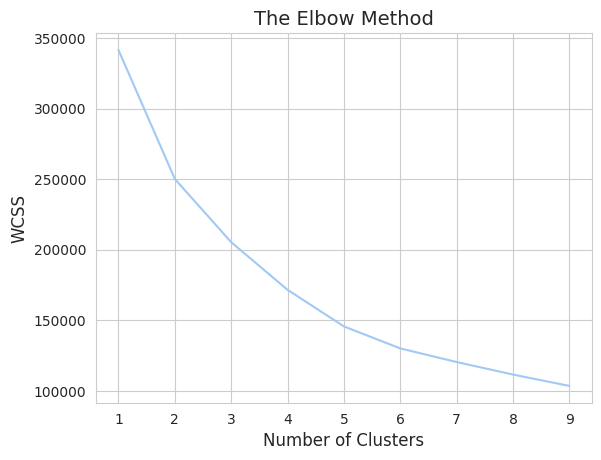

In [ ]:
# Elbow method: try different k.
wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0, n_init = 10)
    kmeans.fit(dataset_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

4 clusters might be the K choices based on WCSS and Elbow chart. Testing K with silhouette test.

### **Performing Silhouette score**

For n_clusters = 2 The average silhouette_score is : 0.25864006834816766
For n_clusters = 3 The average silhouette_score is : 0.25168307185687494
For n_clusters = 4 The average silhouette_score is : 0.2519356672059027
For n_clusters = 5 The average silhouette_score is : 0.2653661445404622
For n_clusters = 6 The average silhouette_score is : 0.251230743876233


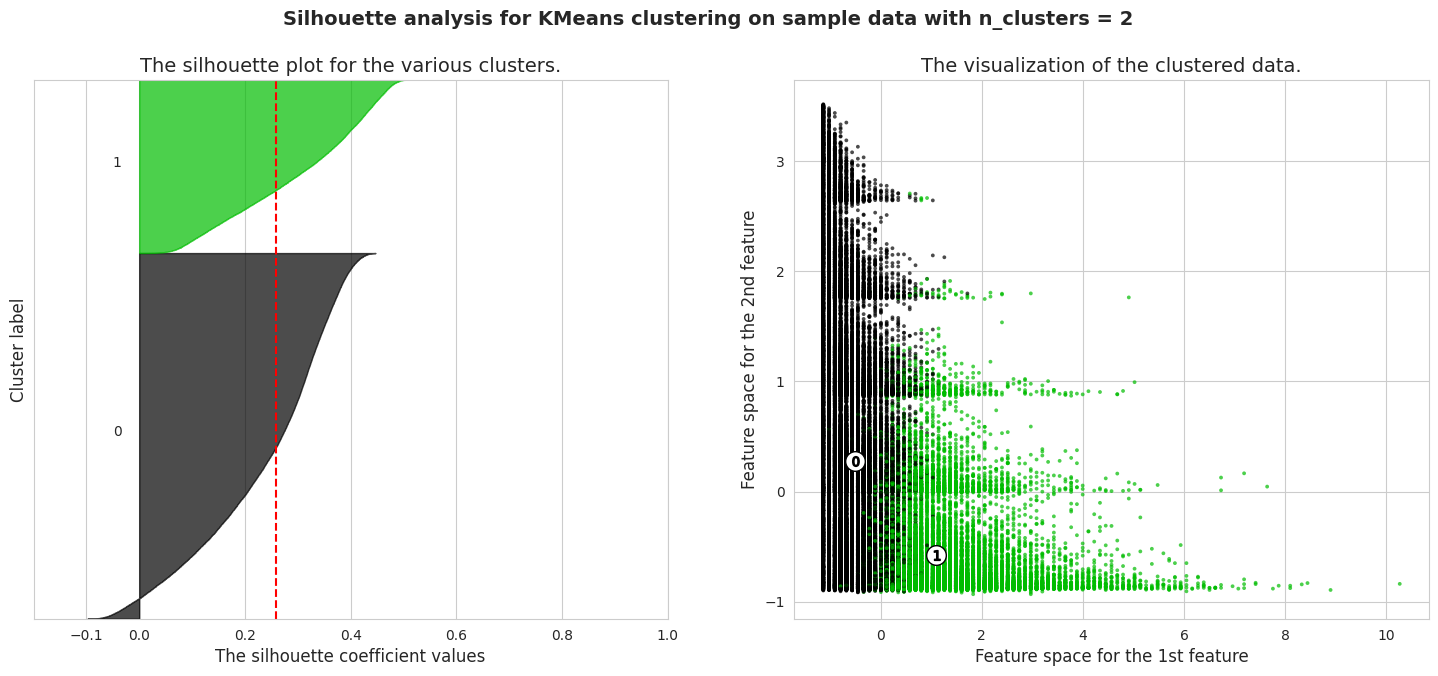

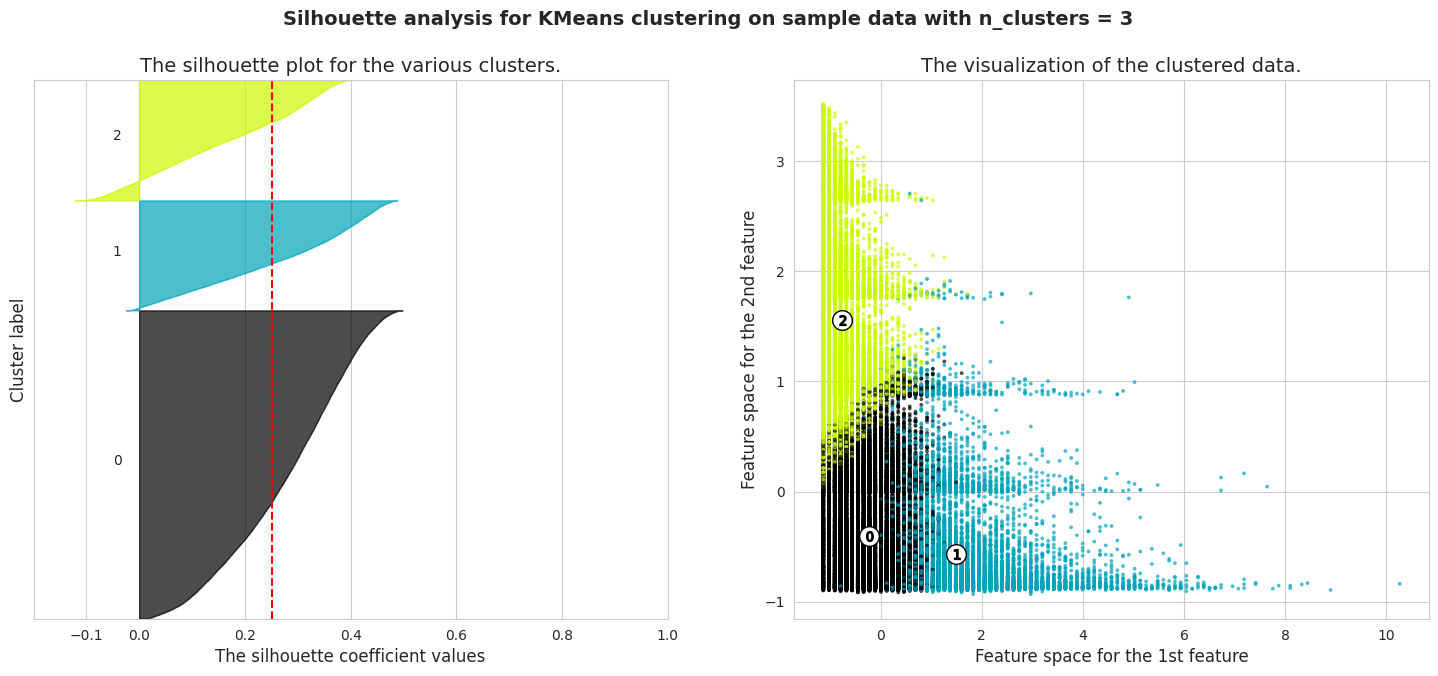

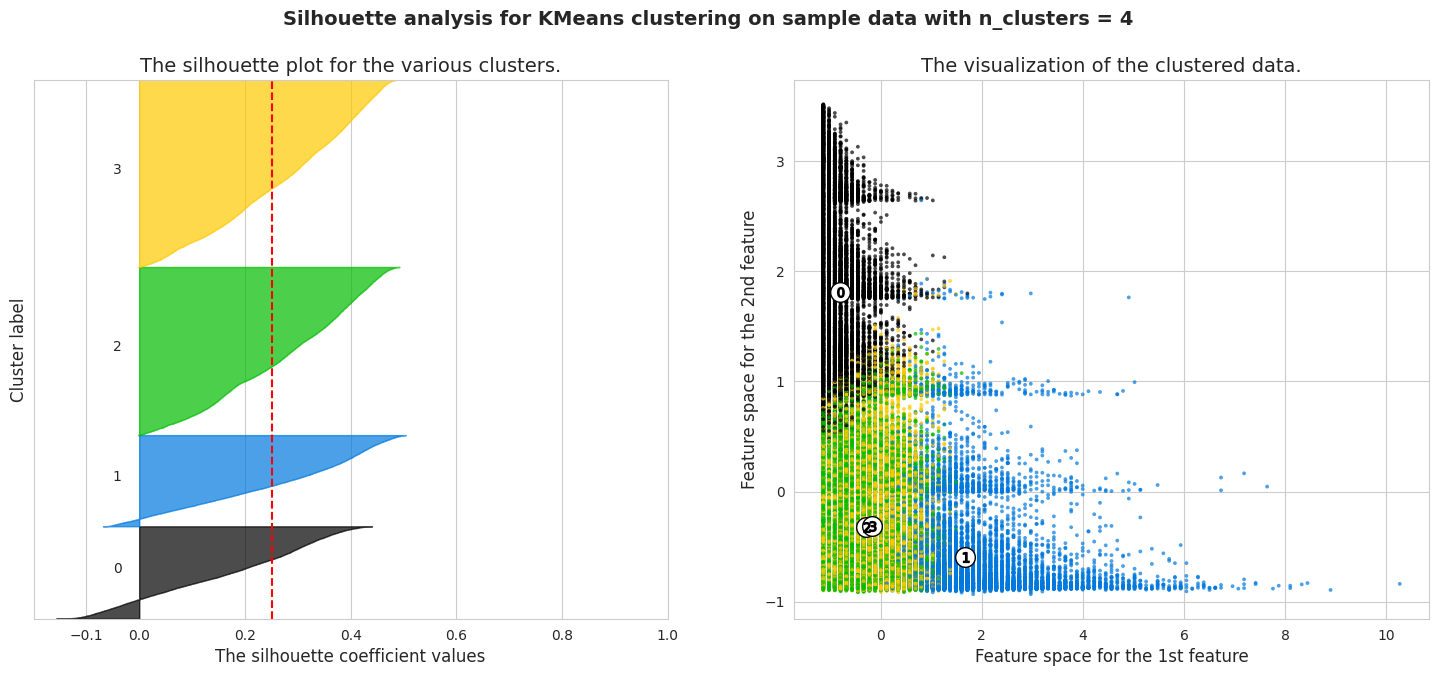

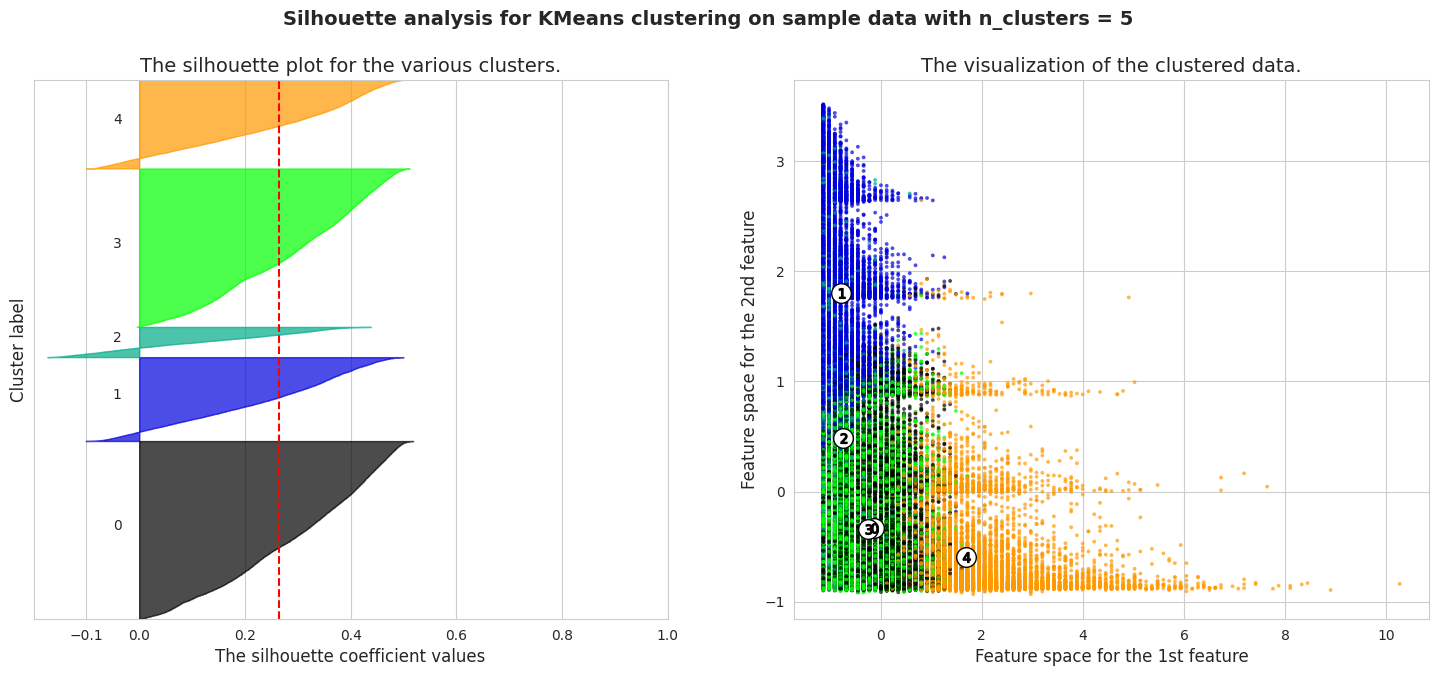

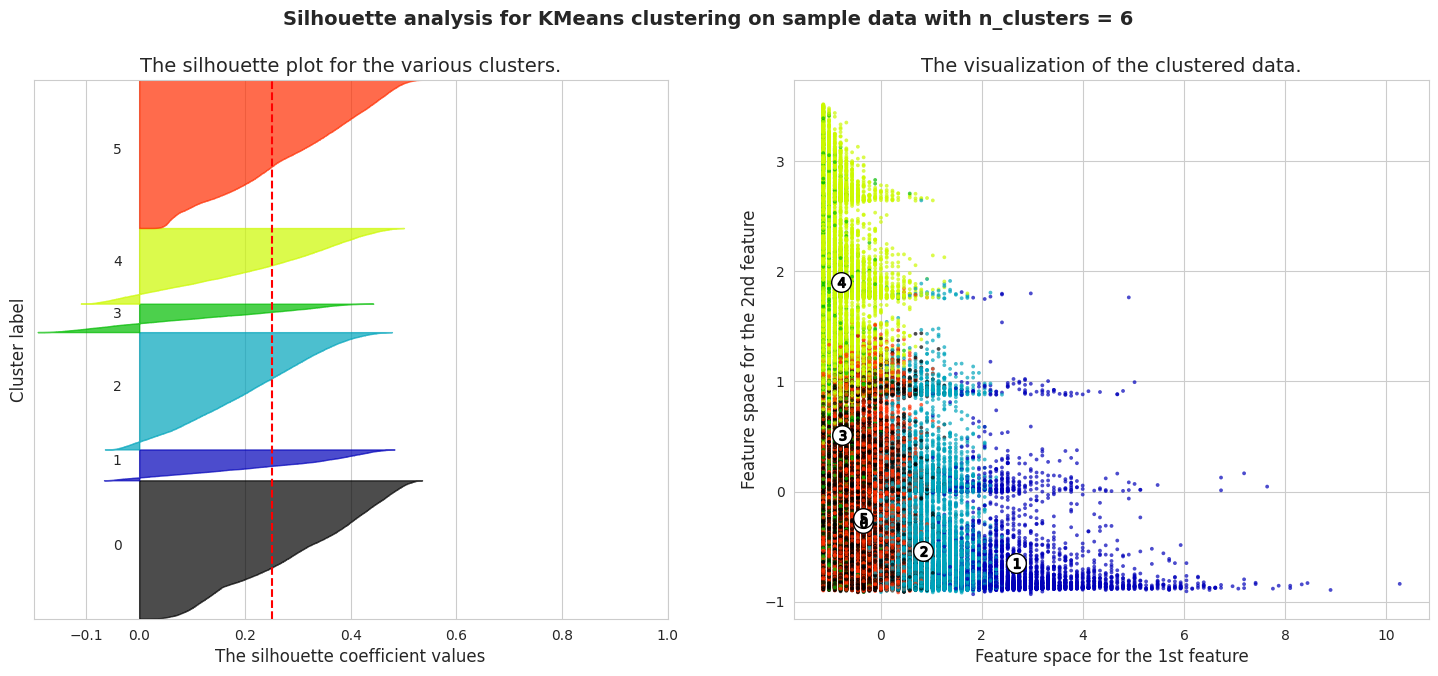

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(dataset_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 10)
    cluster_labels = clusterer.fit_predict(dataset_scaled)

    silhouette_avg = silhouette_score(dataset_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(dataset_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2.scatter(dataset_scaled.iloc[:, 0], dataset_scaled.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

📊 Silhouette test shows a medium-low value for all Ks, with K=5 having the highest score, however the preferred choice is on K=4. If we check the distribution of the test by cluster, we observe a better consistency for K=4 and also the clusters sizes look more granular.

# **7.** Performing hierarchical clustering and creating a dendogram.

# **Dendogram**

For hierarchical clustering I use scaled data as there are some features with a large magnitude and these can influence the clusters assignments. Due to this magnitude in some of the features, I will progress with the method *centroid* so those observations won't be isolated from the rest of the clusters.


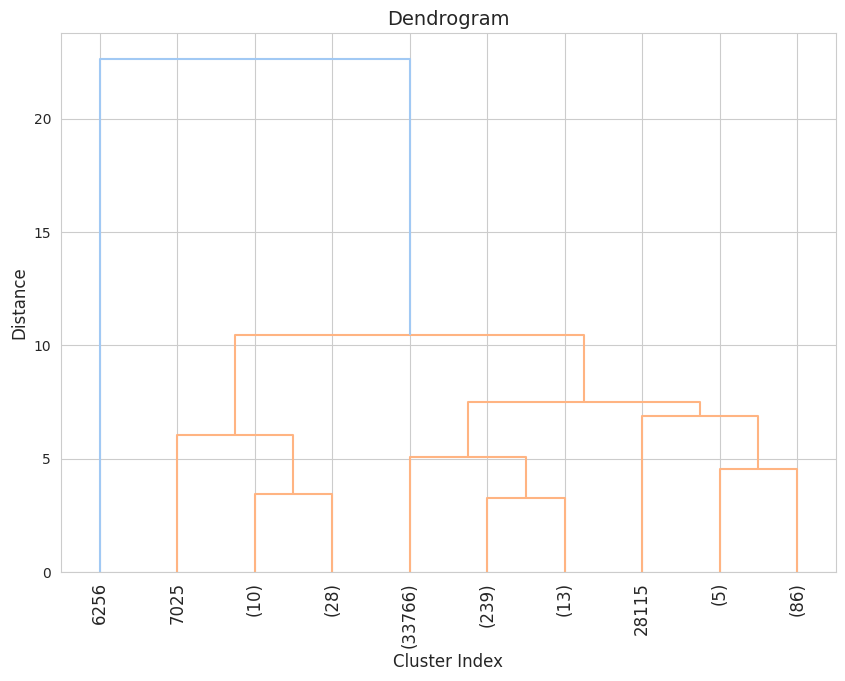

In [ ]:
df_cv_cluster = dataset_scaled

# creating dataset sub-set to run dendogram
# Select a random subset of 50% of the DataFrame
subset_df = df_cv_cluster.sample(frac=0.50, random_state=42)

# Perform hierarchical clustering
Z = linkage(subset_df, method='centroid')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=10, leaf_rotation=90, leaf_font_size=12)
plt.title('Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

📊 The dendogram suggests 3 clusters split, however based on the analysis before, we will chose K=4 confirming the elbow chart results and the better granularity in segmentation suggested by the silhouette charts.

📊 The tests results suggest that K=4, returns the best silhouette scores and clear clusters splits, whereas K=5 and K=3 have better overall scores but not so consistent clusters sizes and scores. K=3 is a more optimal split in the dendogram.
We chose K=4 due silhouette results and the clear drop in the elbow chart with WCSS score jumps flattening beyond K=4.

#**8.** Performing K-Means Clustering

✅ Now that the preferred number of Ks is identified, the work progresses by implementing K-Means clustering and the segments are appended to the customer view for visualisation and insights purposes.


📢 PCA and t-SNE are used to reduce dataset dimension and help visualise the clusters in a 2D space: the groups are fairly clear and identified, with overlaps in their 2D visualisation.


📢 To finalise the recommendation and to provide a view of the identified segments, box-plots are generated on the clusters using the 5 variables frequency, recency, CLV, average unit cost and age. By looking at the distribution of each variable between the clusters, it is possible to extract a profile for each segment and the information that can become useful for the business for its marketing and targeting strategies.

Performing K-Means Clustering for **K=4**

In [ ]:
clusterer = KMeans(n_clusters = 4,
                   random_state=42,
                   n_init = 10)

cluster_labels = clusterer.fit_predict(dataset_scaled)

# Convert cluster labels to a DataFrame to match the structure
df_clusters = pd.DataFrame(cluster_labels, columns=['Cluster'])


# **9.** Cluster number associated with each Customer ID.

In [ ]:
# Append the cluster labels to final_df
df_k4 = pd.concat([df_cv, df_clusters], axis=1)

Checking clusters' sizes

In [ ]:
cluster_summary = df_k4.groupby('Cluster').agg(
    Total_Customers=('Customer ID', 'nunique'),
    Total_Observations=('Customer ID', 'count')
).reset_index()

print(cluster_summary)

   Cluster  Total_Customers  Total_Observations
0        0            21203               21203
1        1            23771               23771
2        2            11665               11665
3        3            11661               11661


# **10.** Createing boxplots to display the clusters profiles with regard to frequency, recency, CLV, average unit cost, Age.

Plotting **K=4**

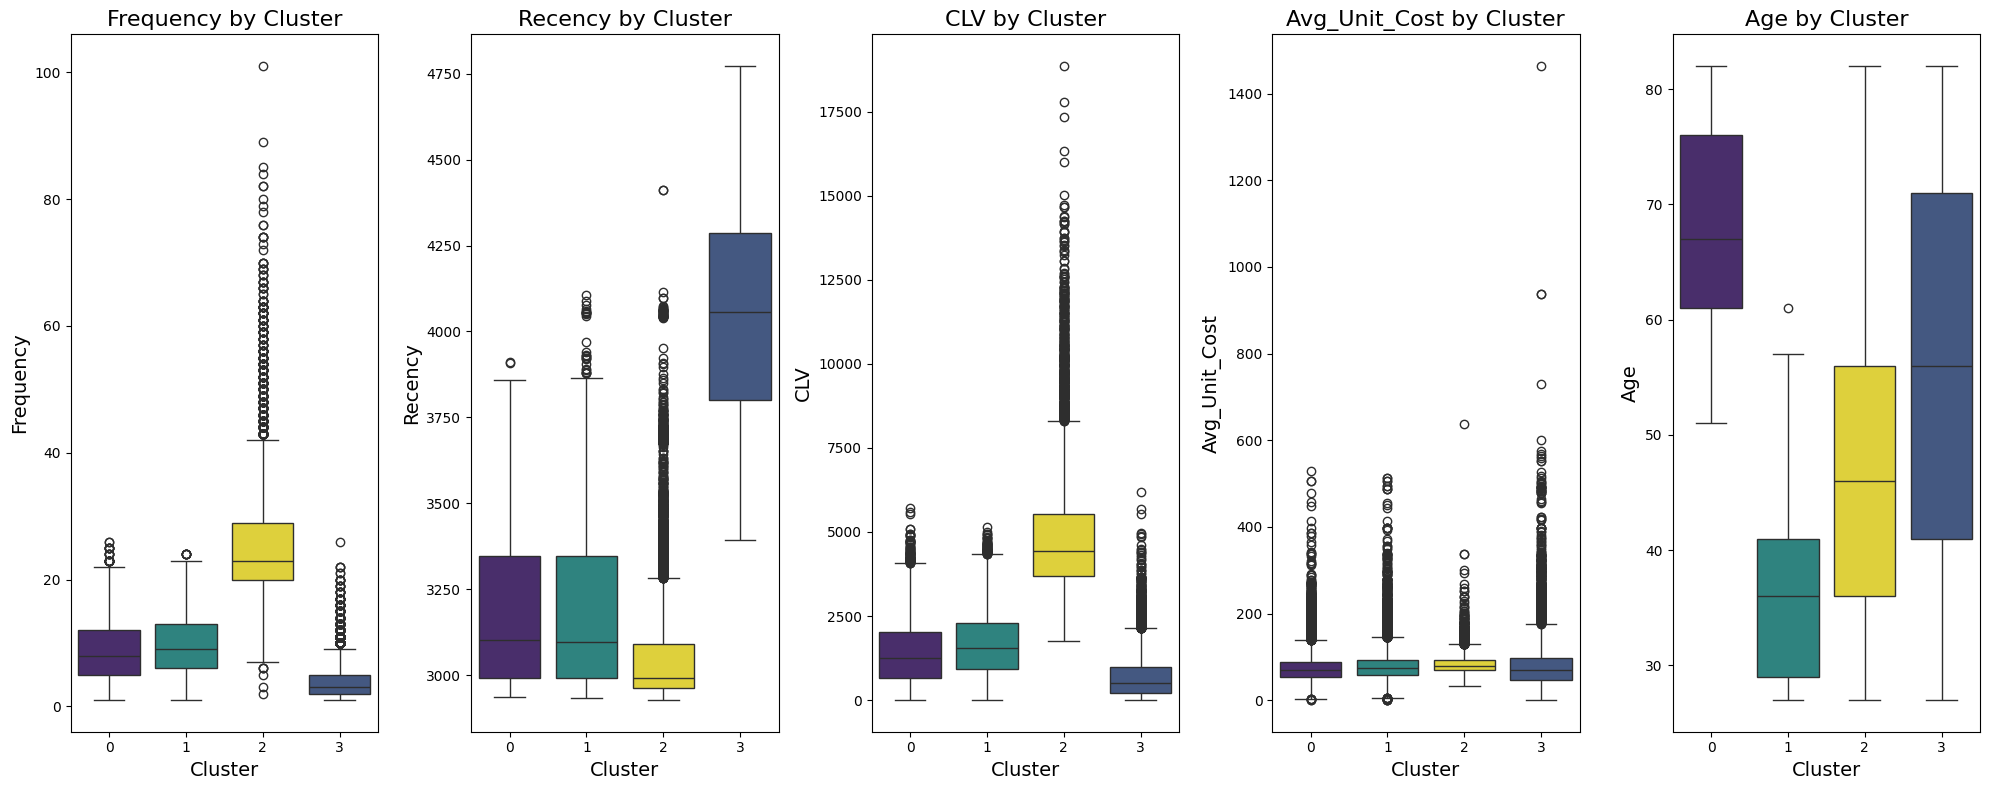

In [ ]:
# Variables to plot (excluding 'Customer ID' and 'Cluster')
variables = ['Frequency', 'Recency', 'CLV', 'Avg_Unit_Cost', 'Age']

custom_palette = {
    '0': sns.color_palette("viridis", as_cmap=True)(0.1),  # Purple for Cluster 0
    '1': sns.color_palette("viridis", as_cmap=True)(0.5),  # Green for Cluster 1
    '2': sns.color_palette("viridis", as_cmap=True)(0.99),  # Yellow for Cluster 2
    '3': sns.color_palette("viridis", as_cmap=True)(0.26)  # Blue for Cluster 3
}

plt.figure(figsize=(20, 8))

for i, var in enumerate(variables):
    plt.subplot(1, len(variables), i + 1)
    sns.boxplot(x='Cluster', y=var, data=df_k4, palette=custom_palette)
    plt.title(f'{var} by Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel(var, fontsize=14)

plt.tight_layout()
plt.show()

🧠 Highlighted key characteristics:

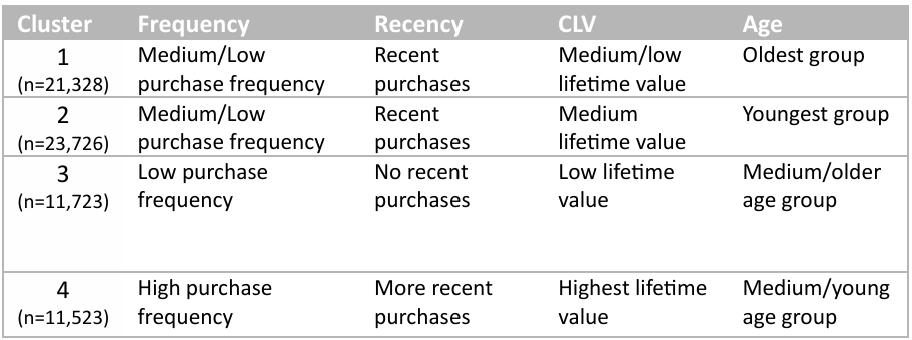

🧠 The profiles summary highlights key differences between clusters, showing how the variables
distributions vary across segments. Average unit cost does not vary significantly by cluster in its mean.

Each cluster has a distinct profile, providing actionable insights to guide new strategic business
decisions and targeting strategies.

#**11.** Performing dimension reduction with PCA and t-SNE to reduce the data to 2D

As clusters are built using multidimensional data (this work includes 5 dimensions), it is difficult to
visualise them. Dimension reduction techniques like PCA simplify the data to 2 dimensions (the work
shows a 65% variance explained with the first two components), while retaining as much variability in
the data as possible, making clusters easier to see in a 2D space.

### **PCA K=4**


### **Generating Dimension reduction with Principal Components to use for 2D visuals of clusters**

In [ ]:
# Use PCA for feature selection.
def plot_variance(pca, width=8, dpi=100):
    # Create a figure.
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    # Explain the variance.
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component",
               title="% Explained variance",
               ylim=(0.0, 1.0))

    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component",
               title="% Cumulative variance",
               ylim=(0.0, 1.0))

    fig.set(figwidth=8, dpi=100)
    return axs

In [ ]:
# Set the number of components to 2.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dataset_scaled) ## using scaled dataset

In [ ]:
df_pca = pd.DataFrame({
    'PC': range(1, len(pca.explained_variance_ratio_) + 1),
    'Explained Variance': pca.explained_variance_ratio_
})

print(df_pca.to_string(index=False))

 PC  Explained Variance
  1            0.443296
  2            0.207491


array([<Axes: title={'center': '% Explained variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative variance'}, xlabel='Component'>],
      dtype=object)

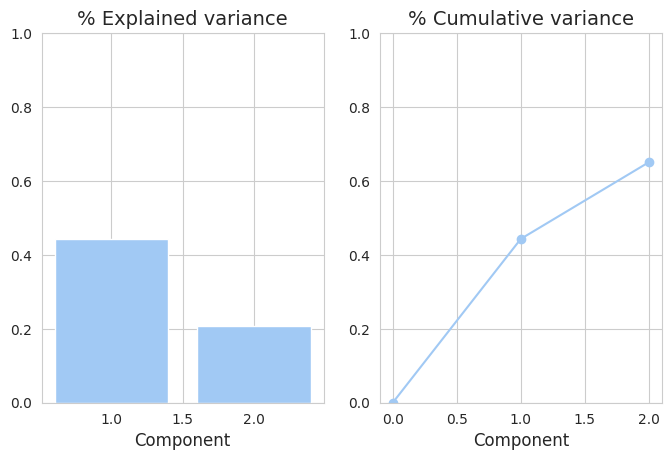

In [ ]:
# View the variance and cumulative variance.
plot_variance(pca)

📊 2 Components explain around 65% of the cumulative variance. They will be fairly representative of all the data when using them for 2D charts.

In [ ]:
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df.head()

,PC1,PC2
0,2.244475,0.034153
1,0.918143,0.200076
2,-1.378955,-0.706405
3,1.194141,0.569650
4,-0.006380,-0.825631


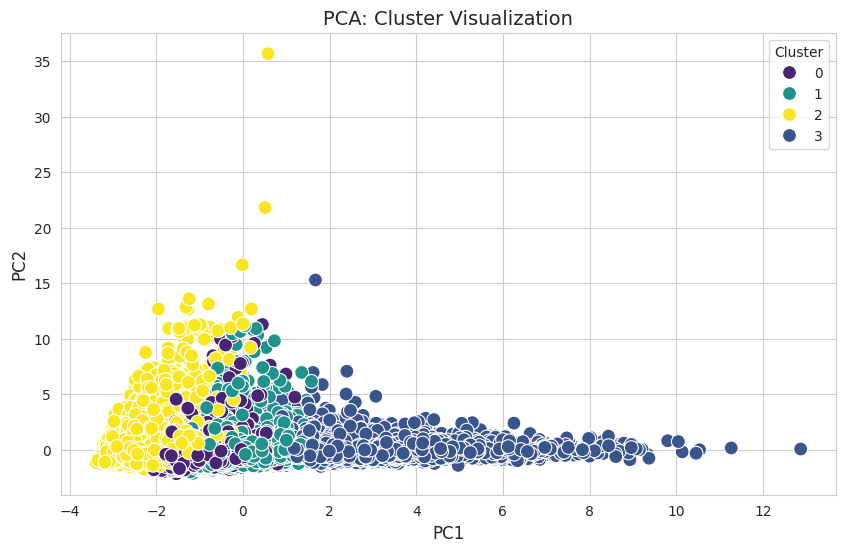

In [ ]:
# Iterate over each k_ column and create scatter plots
PCA_K4 = pd.concat([X_pca_df, df_k4], axis=1)

custom_palette = {
    0: sns.color_palette("viridis", as_cmap=True)(0.1),  # Purple for Cluster 0
    1: sns.color_palette("viridis", as_cmap=True)(0.5),  # Green for Cluster 1
    2: sns.color_palette("viridis", as_cmap=True)(0.99),  # Yellow for Cluster 2
    3: sns.color_palette("viridis", as_cmap=True)(0.26)  # Blue for Cluster 3
}

# Create a scatter plot for PC1 vs. PC2 colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=PCA_K4, x='PC1', y='PC2', hue='Cluster', palette=custom_palette, s=100)

plt.title('PCA: Cluster Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

PCA helps reveal if clusters are well-separated, which helps assess clustering effectiveness and
understand their boundaries. The 2D visualisation shows some overlap in the data, suggesting a less
clear clustering split.

### **PCA and t-SNE K=4**

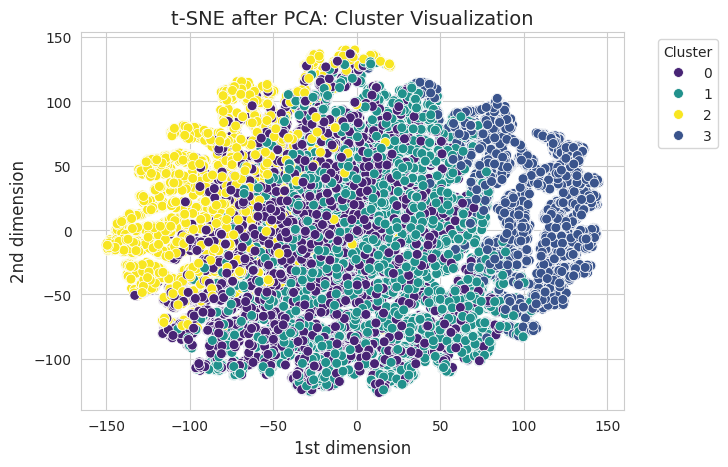

In [ ]:
cluster_labels = df_k4['Cluster'].values

# Apply t-SNE with a perplexity of 30.
TSNE_model = TSNE(n_components=2, perplexity=30.0, random_state=42)
PCA_TSNE_transformed_data = TSNE_model.fit_transform(X_pca_df)

tsne_df = pd.DataFrame(PCA_TSNE_transformed_data, columns=['tsne1', 'tsne2'])
tsne_df['Cluster'] = cluster_labels

custom_palette = {
    0: sns.color_palette("viridis", as_cmap=True)(0.1),  # Purple for Cluster 0
    1: sns.color_palette("viridis", as_cmap=True)(0.5),  # Green for Cluster 1
    2: sns.color_palette("viridis", as_cmap=True)(0.99),  # Yellow for Cluster 2
    3: sns.color_palette("viridis", as_cmap=True)(0.26)  # Blue for Cluster 3
}

palette_mapped = tsne_df['Cluster'].map(custom_palette)

plt.figure(figsize=[7, 4.9])

sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='Cluster', palette=custom_palette, s=50)

plt.title('t-SNE after PCA: Cluster Visualization')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

t-SNE helps to further improve the analysis and visualisation of the clusters, by making distinct
customer segments clearer in a lower-dimensional space.

PCA is often used first to reduce dimensionality, then t-SNE fine-tunes the visualisation of clusters in
the reduced space. While the boundaries are visible in the charts, there is some overlap between
clusters, making it difficult to fully visualise these multidimensional groups in a 2D space and reveal
the complex, non-linear relationships between features crucial for segmentation.